In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install gdown scanpy mygene numpy scikit-learn seaborn matplotlib openai hnswlib xgboost python-dotenv


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
import mygene
%matplotlib inline
import pickle
import sklearn
import random
import scanpy as sc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import openai
# set openai api key in .env file or OPENAI_API_KEY environment variable
np.random.seed(202310)
# use hnswlib for NN classification
try:
    import hnswlib
    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print("hnswlib not installed! We highly recommend installing it for fast similarity search.")
    print("To install it, run: pip install hnswlib")
from scipy.stats import mode

/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load sampled Aorta data
Available at https://drive.google.com/drive/folders/1LgFvJqWNq9BqHbuxB2tYf62kXs9KqL4t?usp=share_link

In [4]:
from src.utils import download_gdrive_file

# URL of the Google Drive file
url = "https://drive.google.com/file/d/173JIFqMxitl8XAdsvQdWHtkuBpNQn_QW/view?usp=drive_link"

sample_adata_path = download_gdrive_file(url, "data/sample_aorta_data_updated.h5ad")


In [5]:
sampled_adata = sc.read_h5ad(sample_adata_path)

/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
mapping_dict_phenotype = {
 'affected_1': 'Ascending only',
 'affected_2': 'Ascending only',
 'affected_3': 'Ascending w/ root',
 'affected_4': 'Ascending only',
 'affected_5': 'Ascending w/ root',
 'affected_6': 'Ascending to descending',
 'affected_7': 'Ascending w/ root',
 'affected_8': 'Ascending w/ root',
 'control_1':'Control',
 'control_2':'Control',
 'control_3':'Control'
}
sampled_adata.obs['phenotype'] = sampled_adata.obs.patient.map(mapping_dict_phenotype)

### The following two functions generate GenePT-s cell embeddings 

In [7]:
def get_seq_embed_gpt(X, gene_names, prompt_prefix="", trunc_index = None):
    n_genes = X.shape[1]
    if trunc_index is not None and not isinstance(trunc_index, int):
        raise Exception('trunc_index must be None or an integer!')
    elif isinstance(trunc_index, int) and trunc_index>=n_genes:
        raise Exception('trunc_index must be smaller than the number of genes in the dataset')
    get_test_array = []
    for cell in (X):
        zero_indices = (np.where(cell==0)[0])
        gene_indices = np.argsort(cell)[::-1]
        filtered_genes = gene_indices[~np.isin(gene_indices, list(zero_indices))]
        if trunc_index is not None:
            get_test_array.append(np.array(gene_names[filtered_genes])[0:trunc_index]) 
        else:
            get_test_array.append(np.array(gene_names[filtered_genes])) 
    get_test_array_seq = [prompt_prefix+' '.join(x) for x in get_test_array]
    return(get_test_array_seq)

In [33]:
def get_gpt_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return np.array(openai.embeddings.create(input=[text], model=model).data[0].embedding)

In [9]:
N_TRUNC_GENE = 1000
sample_cells_data = get_seq_embed_gpt(
    sampled_adata.X,
    np.array(sampled_adata.var.index), 
    prompt_prefix = 'A cell with genes ranked by expression: ',
    trunc_index=N_TRUNC_GENE
)

In [27]:
sample_cells_data[:5]

['A cell with genes ranked by expression: MALAT1 CD74 MT-CO3 TMSB4X HLA-DRA B2M FTL MT-ATP6 HLA-DPA1 MT-ND3 MT-ND1 MT-CO1 HLA-DRB1 C1QB MT-CYB C1QC C1QA MT-CO2 FTH1 CST3 HLA-DPB1 ITM2B ACTB TMSB10 CD14 MT-ND4 SAT1 CEBPD FOS HLA-DQB1 DUSP1 AIF1 NEAT1 HLA-DQA1 PSAP RPLP1 SELENOP RPL41 MT-ND2 TXNIP TYROBP EEF1A1 C3 TPT1 RPS18 RGS1 MARCKS HLA-A RPL28 RPL39 JUN RPL37 UBC RPL30 MT-ND5 RPS19 FAU RPL13 RPS29 HSPA1A ITGB2 MS4A6A KLF6 DDX5 PTPRC RPS3A FCGR3A RPL10 SRP14 HNRNPU RPS2 HCST RPL26 RPL37A HLA-B H3F3A FCER1G RPS23 CLEC7A RPL34 CTSB JUND ATP5F1E CD63 RGS2 LST1 RPL11 MSR1 RPS28 CSF1R HSPB1 RPS15 ZFP36L1 HNRNPA2B1 CD81 VMP1 JUNB RPS15A HLA-DQA2 H3F3B FOLR2 OAZ1 IFITM3 CTSZ FGL2 MEF2A IER3 RPL36 NPC2 S100A11 RPS6 SERF2 CYBA RPS4X LAPTM5 RPS27 PNISR MYL6 RPS14 GRN SRGN RPL27A MNDA CD163 PTMA SON ACTG1 RPL3 ARPC3 RPS9 RPS21 RPS12 HLA-C TUBA1B CTSC PNRC1 SAMHD1 MS4A7 RPS24 LAMP2 RPS27A RPL7A RPS7 DDX17 KCTD12 CD68 ACTR2 ENO1 RSRC2 GAPDH ATP5MG SAP18 INSIG1 ATP5MC2 IFNGR1 FYB1 UQCR10 NACA FXYD

# Generate GenePT-s embeddings

29M tokens
text-embedding-ada-002: $2.93 - 54 minutes
text-embedding-3-small: $0.56 - 46 minutes

In [34]:
sampled_cell_aorta_gpt = []
for x in sample_cells_data:
    sampled_cell_aorta_gpt.append(get_gpt_embedding(x))
sampled_cell_aorta_gpt = np.array(sampled_cell_aorta_gpt)

### UMAP visualizations by phenotype, cell type, and patient id

/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


([], [])

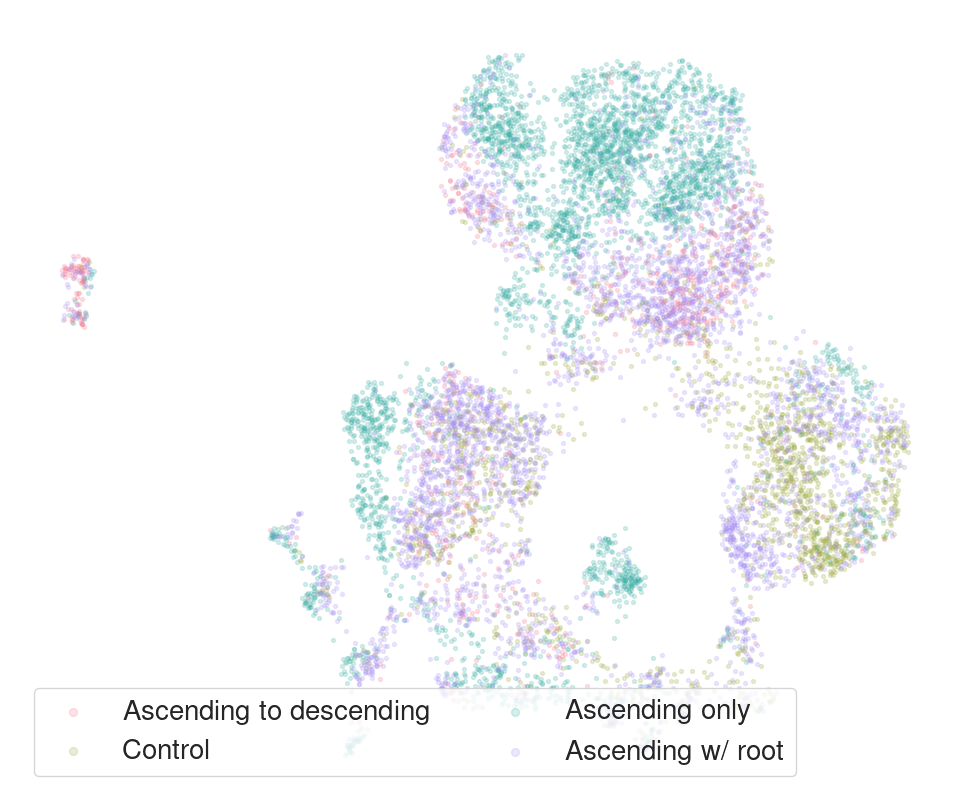

In [35]:
# Assuming sampled_adata.X.A is your input data in the form of a numpy array
# PCA dimension reduction to 50 dimensions
pca = sklearn.decomposition.PCA(n_components=50)
pca_result = pca.fit_transform(sampled_cell_aorta_gpt)
# Compute UMAP on the PCA-reduced data
# embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1).fit_transform(sampled_cell_aorta_gpt)
embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1).fit_transform(pca_result)

plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.phenotype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


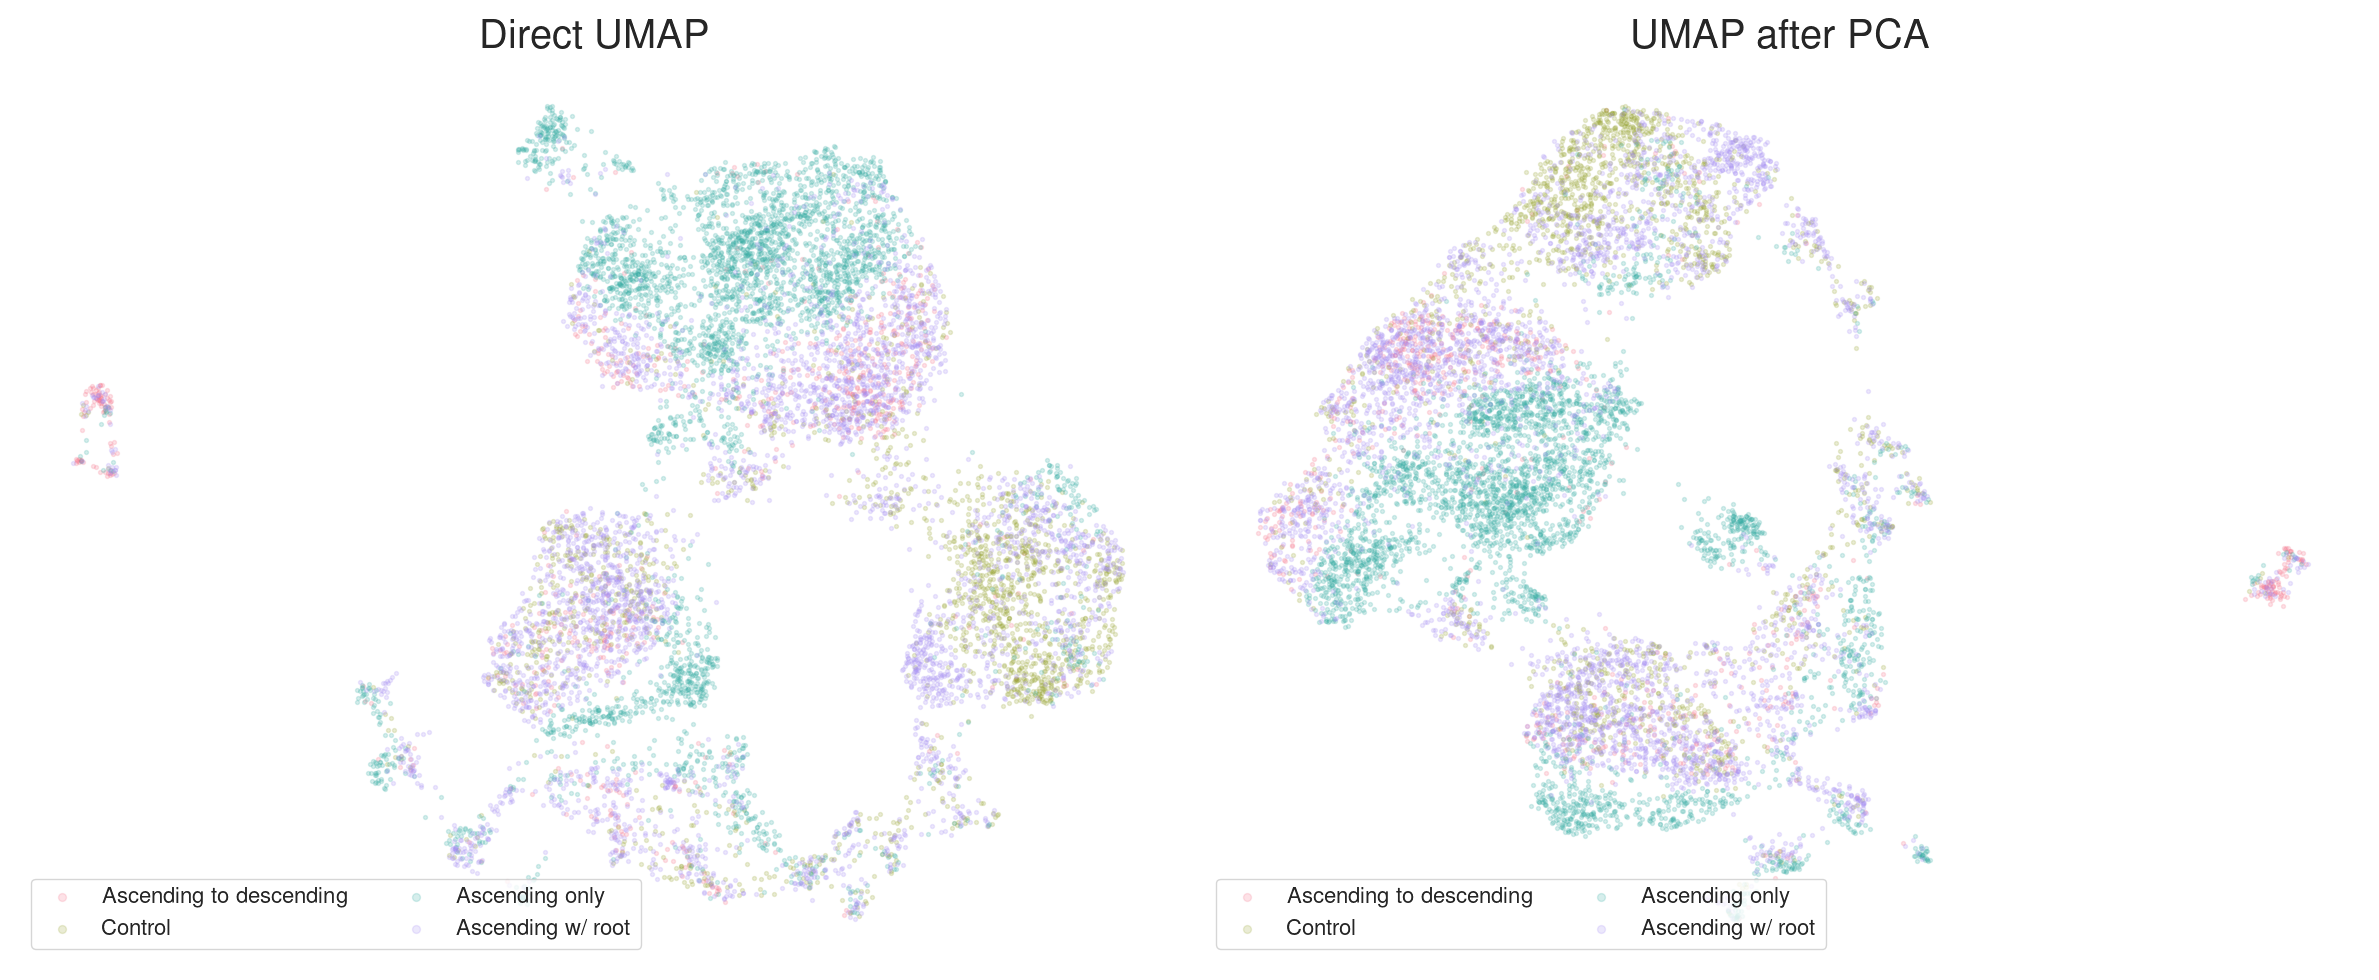

In [36]:
# PCA dimension reduction to 50 dimensions
pca = sklearn.decomposition.PCA(n_components=50)
pca_result = pca.fit_transform(sampled_cell_aorta_gpt)

# Create two UMAP embeddings
embedding_direct = umap.UMAP(min_dist=0.5, spread=1).fit_transform(sampled_cell_aorta_gpt)
embedding_pca = umap.UMAP(min_dist=0.5, spread=1).fit_transform(pca_result)

# Set up the figure with two subplots
plt.rcParams['axes.facecolor'] = 'white'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set random seeds
random.seed(23)
np.random.seed(2023)

# Prepare colors
all_labels = np.unique(sampled_adata.obs.phenotype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))

# Function to create plot
def plot_umap(embedding, ax, title):
    for i, label_name in enumerate(all_labels):
        ax.scatter(embedding[sampled_adata.obs.phenotype==label_name, 0], 
                  embedding[sampled_adata.obs.phenotype==label_name, 1], 
                  s=2, label=label_name, color=colors[i], alpha=0.2)
    leg = ax.legend(prop={'size': 8}, loc='lower left', ncol=2)
    for lh in leg.get_lines(): 
        lh.set_alpha(1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

# Create both plots
plot_umap(embedding_direct, ax1, 'Direct UMAP')
plot_umap(embedding_pca, ax2, 'UMAP after PCA')

plt.rcParams["legend.markerscale"] = 2.0
plt.tight_layout()

([], [])

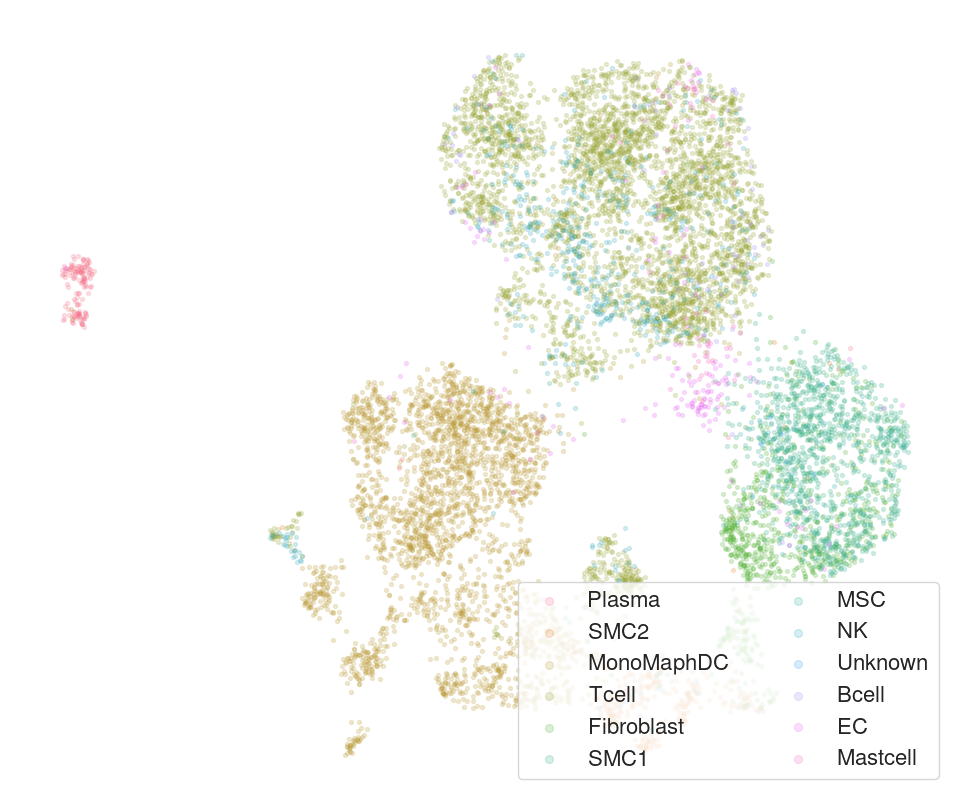

In [37]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.celltype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.celltype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.celltype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 8},loc='lower right',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0

for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

([], [])

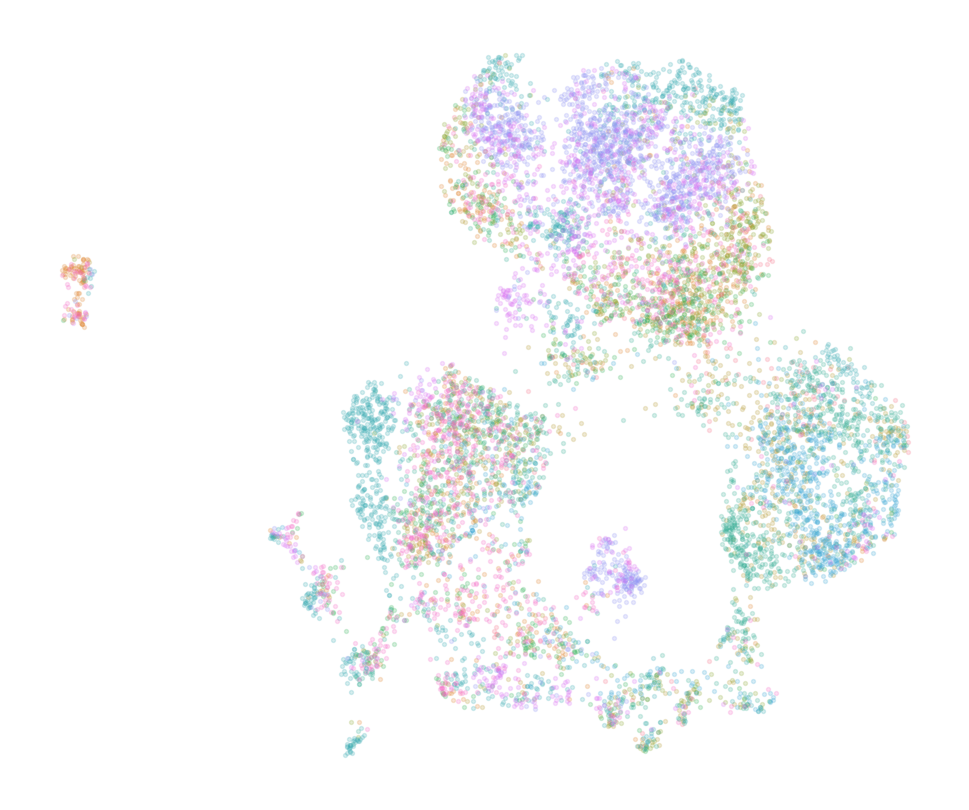

In [38]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.patient)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.patient==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.patient==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
# leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2,bbox_to_anchor=(1.1, 0.10))
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

### Add quantitative data to measure the batch effect and the amount of biology encoded in the embeddings

In [39]:
# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(sampled_cell_aorta_gpt, 
                                                    sampled_adata.obs.phenotype,
                                                    test_size=0.20, random_state=2023)

# Verify the split
print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")

Training set size (X_train): 7700
Test set size (X_test): 1925


***text-embedding-3-small***

* Accuracy: 0.5641558441558442
* Precision: 0.5521841522756094
* Recall: 0.5641558441558442
* f1: 0.49828870665717223

***text-embedding-ada-002***
* Accuracy: 0.7361038961038961    
* Precision: 0.6813854595733095
* Recall: 0.7361038961038961
* f1: 0.6952548501861521


In [40]:
# oh super high accuracy! interesting... 
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(np.mean(y_test== y_pred_lr))
print(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred_lr, average='weighted'))

0.7361038961038961
(0.6813854595733095, 0.7361038961038961, 0.6952548501861521, None)


/Users/rj/personal/GenePT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Correlate estimated clusters to patient-level effect

In [41]:
kmeans = MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sklearn.decomposition.PCA(n_components=50).fit_transform(X=sampled_cell_aorta_gpt))
annotation_label = sampled_adata.obs.patient
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.18710006581424707
aMI 0.22460676308629932


### Correlate estimated clusters to cell types

In [42]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]])
annotation_label = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.34569866895840823
aMI 0.5134808457498444


/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/398065480.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annotation_label = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


### Correlate estimated clusters to phenotypes

In [43]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=4, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt)
disease_label = sampled_adata.obs.phenotype
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, disease_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, disease_label))
# print(pd.crosstab(labels, disease_label))

aRI 0.11980969437926034
aMI 0.11097804322999155


## Cell type annotation task
In this block, we demonstrate the performance of GenePT-s and GenePT-w embeddings on cell type annotation tasks in the Aorta dataset. 

In [46]:
from src.utils import get_gene_embeddings
gene_embedding = get_gene_embeddings("text-embedding-ada-002")

gene_names= list(sampled_adata.var.index)
count_missing = 0
EMBED_DIM = 1536 # embedding dim from GPT-3.5
lookup_embed = np.zeros(shape=(len(gene_names),EMBED_DIM))
for i, gene in enumerate(gene_names):
    if gene in gene_embedding:
        lookup_embed[i,:] = gene_embedding[gene]
    else:
        count_missing+=1
genePT_w_emebed = np.dot(sampled_adata.X,lookup_embed)/len(gene_names)
print(f"Unable to match {count_missing} out of {len(gene_names)} genes in the GenePT-w embedding")

Unable to match 5344 out of 23331 genes in the GenePT-w embedding


### We split the Aorta dataset with annotated cell types into 80%/20% train/test split and perform a 10-nearest-neighbor classifier. 
Code credit: the set up for the 10-NN classifier was ported from the scGPT authors at https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb

#### First for GenePT-w emebddings

In [47]:
# Split the data into training and test sets (80/20)
genePT_w_emebed = genePT_w_emebed[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_w_emebed_train, genePT_w_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/1179350613.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


In [65]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_w_emebed_train
test_emebd = genePT_w_emebed_test
neighbors_list_gpt_v1 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = y_train[idx].mode()[0]
    neighbors_list_gpt_v1.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred)
sklearn.metrics.accuracy_score(gt_list, pred_list)

/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/1821146538.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = y_test[k]
/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/1821146538.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = y_train[idx].mode()[0]
/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/1821146538.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neig

0.876235049401976

In [66]:
print('Precision, Recall, F1 (Marco weighted) for GenePT-w embedding: ', \
      sklearn.metrics.precision_recall_fscore_support(gt_list, pred_list,average='macro'))


Precision, Recall, F1 (Marco weighted) for GenePT-w embedding:  (0.8700908370143217, 0.6907046734174582, 0.7355687809340968, None)


#### We next do it for GenePT-s embeddings

In [67]:
# Split the data into training and test sets (80/20)
genePT_s_emebed = sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_s_emebed_train, genePT_s_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/1591900382.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]


In [68]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_s_emebed_train
test_emebd = genePT_s_emebed_test
neighbors_list_gpt_v2 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = y_train[idx].mode()[0]
    neighbors_list_gpt_v2.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred)
sklearn.metrics.accuracy_score(gt_list, pred_list)

/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/2051920383.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = y_test[k]
/var/folders/1w/njpw08_93h73169nbj9b9z700000gp/T/ipykernel_21156/2051920383.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = mode(y_train[idx], axis=0)


TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

In [23]:
print('Precision, Recall, F1 (Marco weighted) for GenePT-s embedding: ', \
      sklearn.metrics.precision_recall_fscore_support(gt_list, pred_list,average='macro'))

Precision, Recall, F1 (Marco weighted) for GenePT-s embedding:  (0.9113633859147423, 0.6816136346147836, 0.7224098054713864, None)
